In [1]:
import commonfunctions as cf # this a custom module found the commonfunctions.py
import skimage.io as io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray, gray2rgb
from skimage import filters, morphology, measure, feature
from skimage.transform import probabilistic_hough_line, rotate
from skimage.draw import ellipse_perimeter
import math

# Show the matlpotlib figures inside the notebook
%matplotlib inline

In [2]:
def eliminate_points_on_almost_straight_line(hull):
    if hull.shape[0] <= 4:
        return hull
    i = 0
    while i < hull.shape[0]:
        m1,_,_ = line(hull[i - 1], hull[i])
        m2,_,_ = line(hull[i], hull[(i + 1) % hull.shape[0]])
        if abs((m2 - m1) / (1 + m1 * m2)) <= 1E-2:
            hull = np.delete(hull, i, axis=0)
            i -= 1
        i += 1
    return hull

def approx_hull_to_rectangular_shape(hull):
    while hull.shape[0] > 4:
        min_pair = ()
        min_dist = math.inf
        for i in range(hull.shape[0]):
            p = hull[i], hull[(i + 1) % hull.shape[0]], i
            d = distance(p)
            if d < min_dist:
                min_pair = p
                min_dist = d
        p1, p2, i = min_pair
        # # debug
        # img_copy = np.copy(image)
        # for i in range(hull.shape[0]):
        #     cv2.circle(img_copy, (hull[i][0],hull[i][1]), 4, (0, 0, 255), -1)
        #     cv2.imshow("ta" + str(asd), img_copy)
        #     cv2.waitKey(0)
        # #debug
        p_int = intersection(hull[i - 1], p1, p2, hull[(i + 2) % hull.shape[0]])
        hull[i] = p_int
        hull = np.delete(hull, [i, (i + 1) % hull.shape[0]], axis=0)
        if i > hull.shape[0]:
            hull = np.insert(hull, 0, p_int, axis=0)
            continue
        hull = np.insert(hull, i, p_int, axis=0)
    return hull

def fix_perspective(image):
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    # #debug
    # cf.show_images([edged, gray])
    # #debug
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    c = max(cnts, key = cv2.contourArea)
    hull = cv2.convexHull(c)[:, 0,:]
    # # debug
    # cv2.drawContours(image, [hull], -1, (0, 0, 255), 1)
    # # debug
    hull = eliminate_points_on_almost_straight_line(hull)
    rect = approx_hull_to_rectangular_shape(hull)
    # cv2.drawContours(image, [rect], -1, (255, 0, 0), 2)

    return four_point_transform(image, rect)

In [3]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # # debug
    # print(rect)
    # for x in rect:
    #     cv2.circle(image, tuple(x), 4, (0, 0, 255), -1)
    # # debug

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    fixed = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the fixed image
    return fixed

In [4]:
def order_points(pts):
    # sort the points based on their x-coordinates
    pts_indexes = np.argsort(pts[:, 0])
    xSorted = pts[pts_indexes, :]
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    tl_index = 0
    if xSorted[0][1] < xSorted[1][1]:
        tl_index = pts_indexes[0]
    else:
        tl_index = pts_indexes[1]
    result = []
    for i in range(tl_index, tl_index + 4, 1):
        result.append(pts[i % 4])
    return np.array(result, dtype="float32")

In [5]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(o1, p1, o2, p2):
    L1 = line(o1, p1)
    L2 = line(o2, p2)
    if abs(L1[0] - L2[0]) <= 0.01:
        return False
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = int(round(Dx / D))
        y = int(round(Dy / D))
        return [x, y]
    else:
        return False

def distance(p):
    p1, p2,_ = p
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [6]:
def line_one_point(image, start_point, degree, color, thickness):
    end_point = (int(round(start_point[0] + 4096 * math.cos(degree * np.pi / 180.0))), int(round(start_point[1] + 4096 * math.sin(degree * np.pi / 180.0))))
    print(end_point)
    cv2.line(image, start_point, end_point, color, thickness) 

In [7]:
# # img = io.imread("Capture.JPG", as_gray=True)
# img = io.imread("unknown.png", as_gray=True)
def deskew(img):
    edges = filters.sobel(img)

    low = 0.05
    high = 0.2
    lowt = (edges > low).astype(int)
    hight = (edges > high).astype(int)
    edges = filters.apply_hysteresis_threshold(edges, low, high)

    # coords = feature.corner_peaks(feature.corner_harris(edges), min_distance=5, threshold_rel=0.02)
    # coords_subpix = feature.corner_subpix(edges, coords, window_size=13)
    # fig, ax = plt.subplots()
    # ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
    #         linestyle='None', markersize=6)

    lines = probabilistic_hough_line(edges)
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in lines]
    deg_angles = [np.degrees(np.arctan(x)) for x in slopes]

    histo = np.histogram(deg_angles, bins=180)
    # most frequent slope of all lines
    rotation_number = histo[1][np.argmax(histo[0])]

    rotated = rotate(img, rotation_number, resize=True)
    return rotated

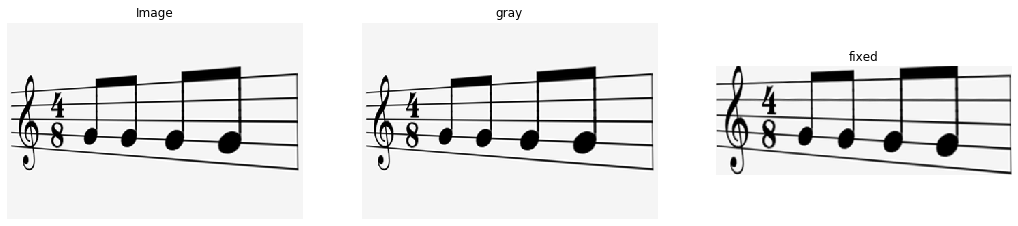

In [17]:
image = cv2.imread("test4.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# deskew(gray)
# cf.show_images([image, gray, fixed], ["Image", "gray", "fixed"])
fixed = fix_perspective(gray)
cf.show_images([image, gray, fixed], ["Image", "gray", "fixed"])